In [ ]:
# !pip freeze

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pip install transformers
# !pip install torch-lr-finder

In [ ]:
import random
import re
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
BASE_URL = '/content/drive/MyDrive/AWSHACK/'
PATH = BASE_URL + 'final-merged-data-50.csv'

In [ ]:
RANDOM_SEED = 2
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [ ]:
raw_data_df = pd.read_csv(PATH)

In [ ]:
len(raw_data_df['song_id'].drop_duplicates())

1241

In [ ]:
raw_data_df.isna().sum()

Unnamed: 0    0
song_id       0
lyrics        0
Streams       0
Date          0
Genre         0
label         0
dtype: int64

In [ ]:
data_df = raw_data_df.rename({'Streams':'streams', 'Genre':'genre', 'Date':'date'}, axis=1)

In [ ]:
data_df.shape

(49353, 7)

In [ ]:
# Cast the numerical features to floats.
data_df['streams'] = data_df['streams'].astype('int32')
# data_df["price"] = data_df["price"].astype('float')

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49353 entries, 0 to 49352
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  49353 non-null  int64 
 1   song_id     49353 non-null  int64 
 2   lyrics      49353 non-null  object
 3   streams     49353 non-null  int32 
 4   date        49353 non-null  object
 5   genre       49353 non-null  object
 6   label       49353 non-null  int64 
dtypes: int32(1), int64(3), object(3)
memory usage: 2.4+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'label score')

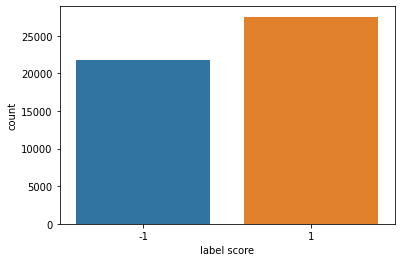

In [ ]:
sns.countplot(data_df.label)
plt.xlabel('label score')

In [ ]:
def to_binary_class(value):
  if value < 0:
    return 0
  else:
    return 1

In [ ]:
data_df.label = data_df.label.apply(to_binary_class)

In [ ]:
class_names = ['bearish', 'bullish']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'bearish'), Text(0, 0, 'bullish')]

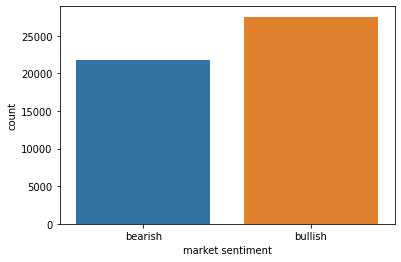

In [ ]:
ax = sns.countplot(data_df.label)
plt.xlabel('market sentiment')
ax.set_xticklabels(class_names)

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Check for the max len of token through out the dataset
sen_w_feats = data_df['lyrics'].drop_duplicates()
max_len = 0
size = []
# For every sentence...
for sent in sen_w_feats:
    if sent != None or sent != '':
      # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
      input_ids = tokenizer.encode(sent, add_special_tokens=True)
      size.append(len(input_ids))
      # Update the maximum sentence length.
      max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)
print('Avg Length: ', sum(size)/len(size))
print('50th Percentile', np.percentile(size, 50))
print('90th Percentile', np.percentile(size, 90))

Token indices sequence length is longer than the specified maximum sequence length for this model (934 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  1918
Avg Length:  579.8265993265993
50th Percentile 536.5
90th Percentile 892.8999999999999


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


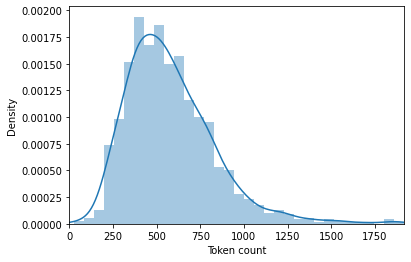

In [ ]:
sns.distplot(size)
plt.xlim([0, max_len]);
plt.xlabel('Token count');

Train Test Val Split

In [ ]:
# Larger batch sizes tend to be better, and we can fit this in memory.
BATCH_SIZE = 32

# I used a smaller learning rate to combat over-fitting that I was seeing in the
# validation loss. I could probably try even smaller.
LR = 2e-5

# Number of training epochs. 
EPOCHS = 6
MAX_LEN = 10
TRAIN_TEST_SPLIT = 0.4
N_CLASSES = 2

In [ ]:
def group_array(data_df, column):
  gb = data_df.groupby([column])
  return [gb.get_group(x) for x in gb.groups]

In [ ]:
group_arr = group_array(data_df, 'date')

In [ ]:
group_arr_train, group_arr_test = train_test_split(
  group_arr,
  test_size=TRAIN_TEST_SPLIT,
  random_state=RANDOM_SEED
)

In [ ]:
group_arr_val, group_arr_test = train_test_split(
  group_arr_test,
  test_size=0.2,
  random_state=RANDOM_SEED
)

In [ ]:
def middle_list(sentences, min_lenght):
  length = len(sentences)
  if length > min_lenght:
    half = length / 2
    half = int(half)
    quad = half / 2
    quad = int(quad)
    sentences = sentences[quad:quad+half]
  return sentences


In [ ]:
def preprocess_lyrics(text):
  sentences = list(set(re.split("  +", text)))
  sentences = middle_list(sentences, 10)
  text_new = ". ".join(sentences)
  sentences = list(re.split(" +", text))
  sentences = middle_list(sentences, 200)
  return " ".join(sentences)

In [ ]:
def dataset_maker(group_arr, max_len, tokenizer):
  target = torch.stack([torch.tensor(x['label'].max()) for x in group_arr])
  table = pd.concat([gb for gb in group_arr])
  unique_songs = table[['song_id', 'lyrics']].drop_duplicates('song_id')
  unique_songs['lyrics'] = unique_songs['lyrics'].apply(preprocess_lyrics)
  unique_songs['unique_song_pos'] = range(0, len(unique_songs))
  mapping_table = pd.merge(table, unique_songs, how='inner', on=['song_id'])
  mapping_table = mapping_table[['song_id', 'unique_song_pos', 'date', 'streams']]
  mapping_table = group_array(mapping_table, 'date')
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []
  sen_w_feats = unique_songs['lyrics']
  print('Encoding all lyrics in the dataset...')
  # For every sentence...
  for sent in sen_w_feats:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = max_len,           # Pad & truncate all sentences.
                          truncation = True,
                          padding = 'max_length',
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                  )
          # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  input_ids = torch.stack(input_ids)
  input_ids_shape = input_ids.size()
  input_ids = torch.reshape(input_ids, (input_ids_shape[0], input_ids_shape[2]))
  attention_masks = torch.stack(attention_masks)
  attention_masks_shape = attention_masks.size()
  attention_masks = torch.reshape(attention_masks, (attention_masks_shape[0], attention_masks_shape[2]))

  return {
      "input_ids":input_ids,
      "attention_mask":attention_masks,
      "unique_songs":unique_songs,
      "mapping_table": mapping_table,
      "targets": target
  }

In [ ]:
data_df_train = dataset_maker(group_arr_train, MAX_LEN, tokenizer)
data_df_test = dataset_maker(group_arr_test, MAX_LEN, tokenizer)
data_df_val = dataset_maker(group_arr_val, MAX_LEN, tokenizer)

Encoding all lyrics in the dataset...
Encoding all lyrics in the dataset...
Encoding all lyrics in the dataset...


In [ ]:
print(data_df_train['input_ids'].shape)
print(data_df_train['attention_mask'].shape)
print(data_df_train['unique_songs'].shape)
print(len(data_df_train['mapping_table']))
print(data_df_train['targets'].shape )
print(data_df_test['input_ids'].shape)

torch.Size([1178, 10])
torch.Size([1178, 10])
(1178, 3)
663
torch.Size([663])
torch.Size([791, 10])


In [ ]:
# Mapping Layer that maps songs to the mapping table
class MappingLayer(nn.Module):
  def __init__(self, group_column='date'):
    super(MappingLayer, self).__init__()
  
  def forward(self, bert_output, mapping_table):
    x_data = []
    bert_output = bert_output.detach().numpy()
    for gp in mapping_table:
      weighted_predictions = gp.apply(lambda row: bert_output[row['unique_song_pos']] * row['streams'], axis=1)
      total_streams = gp['streams'].max()
      normalized_weighted_predictions = weighted_predictions.apply(lambda x: x / total_streams)
      normalized_weighted_predictions_avg = normalized_weighted_predictions.sum()/len(normalized_weighted_predictions)
      x_data.append(normalized_weighted_predictions_avg)
    return torch.tensor(np.array(x_data), requires_grad=True).float()

In [ ]:
# Lyrics Sentiment Classifier uses BERT MODEL and Linear Classifier
class LyricsSentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(LyricsSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.dropout = nn.Dropout(p=0.1)
    self.mapping = MappingLayer()
    self.linear = nn.Linear(self.bert.config.hidden_size, 256)
    self.hidden = nn.Linear(256, 2)
    self.sigmoid = nn.Sigmoid()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask, mapping_table):
    base_model_output = self.bert(
      input_ids=input_ids, attention_mask=attention_mask
    )
    pooler_output = base_model_output.pooler_output
    bert_output = self.dropout(pooler_output)
    x = self.mapping(bert_output, mapping_table)
    x = self.linear(x)
    x = self.hidden(x)
    x = self.sigmoid(x)
    return self.softmax(x)

In [ ]:
model = LyricsSentimentClassifier(N_CLASSES)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
optimizer = AdamW(model.parameters(), lr=LR, correct_bias=False)
total_steps =  EPOCHS+1
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=2,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler
):
  model = model.train()
  losses = []
  correct_predictions = 0
  # for d in data_loader:
  input_ids = data_loader["input_ids"].to(device)
  attention_mask = data_loader["attention_mask"].to(device)
  mapping_table = data_loader['mapping_table']
  targets = data_loader["targets"].to(device)
  n_examples = len(mapping_table)
  outputs = model(
    input_ids=input_ids,
    attention_mask=attention_mask,
    mapping_table=mapping_table
  )
  _, preds = torch.max(outputs, dim=1)
  loss = loss_fn(outputs, targets)
  correct_predictions += torch.sum(preds == targets)
  losses.append(loss.item())
  loss.backward()
  nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
  optimizer.step()
  scheduler.step()
  optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

Evaluation

In [ ]:
def eval_model(model, data_loader, loss_fn, device):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    # for d in data_loader:
    input_ids = data_loader["input_ids"].to(device)
    attention_mask = data_loader["attention_mask"].to(device)
    mapping_table = data_loader['mapping_table']
    targets = data_loader["targets"].to(device)
    n_examples = len(mapping_table)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      mapping_table=mapping_table
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 50)
  train_acc, train_loss = train_epoch(
    model,
    data_df_train,
    loss_fn,
    optimizer,
    device,
    scheduler
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    data_df_test,
    loss_fn,
    device
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/6
--------------------------------------------------
Train loss 0.693334698677063 accuracy 0.43288084464555054
Val   loss 0.6936485767364502 accuracy 0.3707865168539326

Epoch 2/6
--------------------------------------------------
Train loss 0.6933153867721558 accuracy 0.43288084464555054
Val   loss 0.6928703784942627 accuracy 0.6292134831460674

Epoch 3/6
--------------------------------------------------
Train loss 0.6929650902748108 accuracy 0.5625942684766214
Val   loss 0.6910296082496643 accuracy 0.6292134831460674

Epoch 4/6
--------------------------------------------------
Train loss 0.6921079158782959 accuracy 0.5671191553544495
Val   loss 0.6894365549087524 accuracy 0.6292134831460674

Epoch 5/6
--------------------------------------------------
Train loss 0.6914213299751282 accuracy 0.5671191553544495
Val   loss 0.6881857514381409 accuracy 0.6292134831460674

Epoch 6/6
--------------------------------------------------
Train loss 0.6908366084098816 accuracy 0.5671191

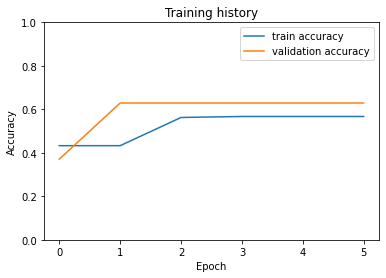

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

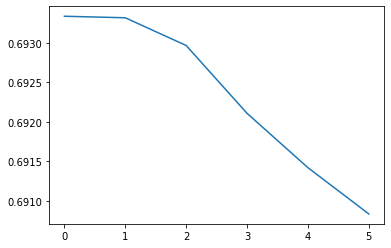

In [ ]:
plt.plot(history['train_loss'])

Loading Models & Validation

In [ ]:
model = LyricsSentimentClassifier(N_CLASSES)
model.load_state_dict(torch.load("best_model_state.bin"))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
# model.eval()

In [ ]:
with torch.no_grad():
    # for d in data_loader:
    input_ids = data_df_val["input_ids"].to(device)
    attention_mask = data_df_val["attention_mask"].to(device)
    mapping_table = data_df_val['mapping_table']
    targets = data_df_val["targets"].to(device)
    n_examples = len(mapping_table)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      mapping_table=mapping_table
    )
    _, preds = torch.max(outputs, dim=1)

val_acc = preds.eq(targets).sum()/len(targets) * 100
print("Accuracy on the validation data: ", val_acc)